In [11]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets

## 1: Set up the historical data which will be used for the Priors

In [12]:
# Number of states and parties
NUM_STATES = 16
NUM_PARTIES = 8
STATES = ["BW", "BY", "BE", "BB", "HB", "HH", "HE", "MV", "NI", "NW", "RP", "SL", "SN", "ST", "SH", "TH"]

In [ ]:
# set random seed
np.random.seed(42)

One issue is that BSW will appear the first time in the election 2025. This already implies that I cannot rely soley on historical election data.

In [13]:
# Voter share for the whole nation 2021 (8 Parties)
historical_shares_nation = np.array([0.241, 0.257, 0.148, 0.115, 0.049, 0.103, 0.000, 0.087])

In [14]:
def get_poll_data(cutoff_date: str, bundestag: bool):
    # Include Polls from 7th of November -> Time when the coalition did break apart
    poll_df = pd.read_csv("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/Resources_all/Polls/output.csv")

    # Filter for the 7th of November and relevant columns
    poll_df = poll_df[poll_df['survey_date'] >= cutoff_date]
    relevant_cols = ["survey_date", "survey_persons", "parliament_id", "institute_id", "result_cdu-csu", "result_spd", "result_gruene",
                    "result_fdp", "result_linke", "result_afd", "result_bsw", "result_sonstige", "result_cdu", "result_csu"]
    poll_df = poll_df[relevant_cols]

    # Add results of cdu and csu in cdu-csu
    poll_df['result_cdu-csu'] = poll_df['result_cdu-csu'].fillna(0) + poll_df['result_cdu'].fillna(0) + poll_df['result_csu'].fillna(0)
    poll_df = poll_df.drop(columns=['result_cdu', 'result_csu'])

    # Only consider polls for bundestag
    if bundestag:
        poll_df = poll_df[poll_df['parliament_id'] == "bundestag"]
    else:
        poll_df = poll_df[poll_df['parliament_id'] != "bundestag"]
    # Drop prefix result_ from column names
    poll_df.columns = poll_df.columns.str.replace('result_', '')

    return poll_df

Get poll data 6 months from the actual election until I start collecting polls for multinomial likelihood (07.11.24). These polls will be combined with the past election result as prior

In [15]:
baseline_polls = get_poll_data("2024-08-23", True)
baseline_polls = baseline_polls[baseline_polls['survey_date'] < "2024-11-07"]
baseline_polls = baseline_polls.drop(columns=['survey_date', 'survey_persons', 'parliament_id', 'institute_id'])
# avergae over all polls
baseline_polls = baseline_polls.mean() / 100
# round and convert to numpy array
baseline_polls = baseline_polls.round(3)
baseline_polls = baseline_polls.to_numpy()

In [ ]:
# Average last election result and baseline polls
voter_shares_nation = (historical_shares_nation + baseline_polls)

#### Dirichlet Regression
Discuss this as a potential addition to the model.

In [ ]:
# Set alpha parameter for dirichlet distribution of prior
a_nation = voter_shares_nation * 100

## 2. Including the Poll Data

In [18]:
nation_polls = get_poll_data("2024-11-07", True)

Create weights for the polls, IDEA: Later polls are more important.
Use a decay function so that polls lose weight over time.

In [21]:
def assign_weights_to_polls(national_polls: pd.DataFrame):
    # Define decay rate
    half_life = 30  # Poll looses half of its weight every 30 days
    decay_rate = np.log(2) / half_life

    # Convert survey_date to datetime format
    national_polls['survey_date'] = pd.to_datetime(national_polls['survey_date'])

    # Compute weights based on poll dates
    poll_dates = np.array(national_polls['survey_date'], dtype="datetime64[D]")
    earliest_poll_date = np.max(poll_dates)  
    time_diffs = (earliest_poll_date - poll_dates).astype("timedelta64[D]").astype(int)  # Days since each poll
    weights = np.exp(-decay_rate * time_diffs)  # Exponential decay

    return weights

In [22]:
for var in ["cdu-csu", "spd", "gruene", "fdp", "linke", "afd", "bsw", "sonstige"]:
    nation_polls[var] = round(nation_polls["survey_persons"] * nation_polls[var] / 100)

# Get weights for each poll
weights = assign_weights_to_polls(nation_polls)
# Drop unnecessary columns
nation_polls = nation_polls.drop(columns=["survey_persons", "institute_id", "survey_date", "parliament_id"])

# Data processing and then store it in lists
nation_polls = nation_polls.fillna(0)
nation_polls.reset_index(drop=True, inplace=True)
survey_results_nation = nation_polls.values.tolist()
sample_size_nation = nation_polls.sum(axis=1).to_list()


## 3: Building the Bayesian Model using PyMC

In [23]:
# Weight the national polls with exponential decay
SCALER = 0.01
survey_results_nation_adj = []
for i in range(len(survey_results_nation)):
    adjusted_shares = [round(weights[i] * voter_share * SCALER) for voter_share in survey_results_nation[i]]
    survey_results_nation_adj.append(adjusted_shares)

sample_size_nation_adj = [sum(adjusted_shares) for adjusted_shares in survey_results_nation_adj]

In this last version, make also the alphas probabilisitic in to follow bayesian guideline to make all unknowns probabilistic. This might lead to more complex posterior and not conjugate prior anymore

In [ ]:
with pm.Model() as nation_model:
    # Quantify uncertainty in historical results and early polls for the prior by gamma distribution
    alpha_nation = pm.Gamma("alpha_nation", alpha=a_nation, beta=2, shape=8)    
    # Dirichlet-Prior
    nation_prior = pm.Dirichlet("voter_share_nation", a=alpha_nation, shape=(NUM_PARTIES,))

    # National level likelihood based on poll results
    # NOTE: For observed I use a list comprehension to multiply each party's voter share by the corresponding weight
    for i in range(len(survey_results_nation)):
        nation_likelihood = pm.Multinomial(
            f"nation_poll_{i}", 
            n=sample_size_nation_adj[i], 
            p=nation_prior, 
            observed=survey_results_nation_adj[i]
        )

## 4: Sampling from the posterior

In [ ]:
with nation_model:
    trace = pm.sample(
        draws=10000,
        chains=4,
        random_seed=42,
        return_inferencedata=True
        )

Initializing NUTS using jitter+adapt_diag...
/home/juliusd/miniconda3/envs/bayes/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [voter_share_nation]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 125 seconds.


## 5: Analyzing the results

In [26]:
# summarize 
summary = az.summary(trace)
summary.to_csv("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/results/Final/summary.csv")

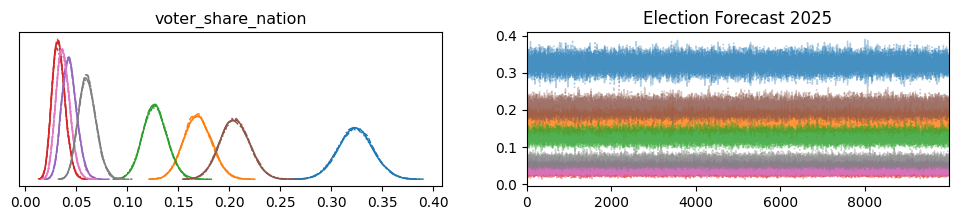

In [27]:
# 5: Analyzing the results
# If I get the colors to represent the parties, use this list
party_colors = ['black', 'red', 'green', 'yellow', 'pink', 'blue', 'purple', 'grey']
party_labels = ['CDU', 'SPD', 'Greens', 'FDP', 'Left', 'AfD', 'BSW', 'Others']

# Plot trace for national posterior
az.plot_trace(trace, var_names=["voter_share_nation"])
plt.title("Election Forecast 2025")
plt.savefig("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/results/Final/posterior_nation.png")
plt.show()

## Prediction for the Election
For the Non-Bayesian, in the following there will be a more classical summary of the posterior. Not as meaningful as the posteriors and traces above, but maybe more intuitive to understand for some 😃

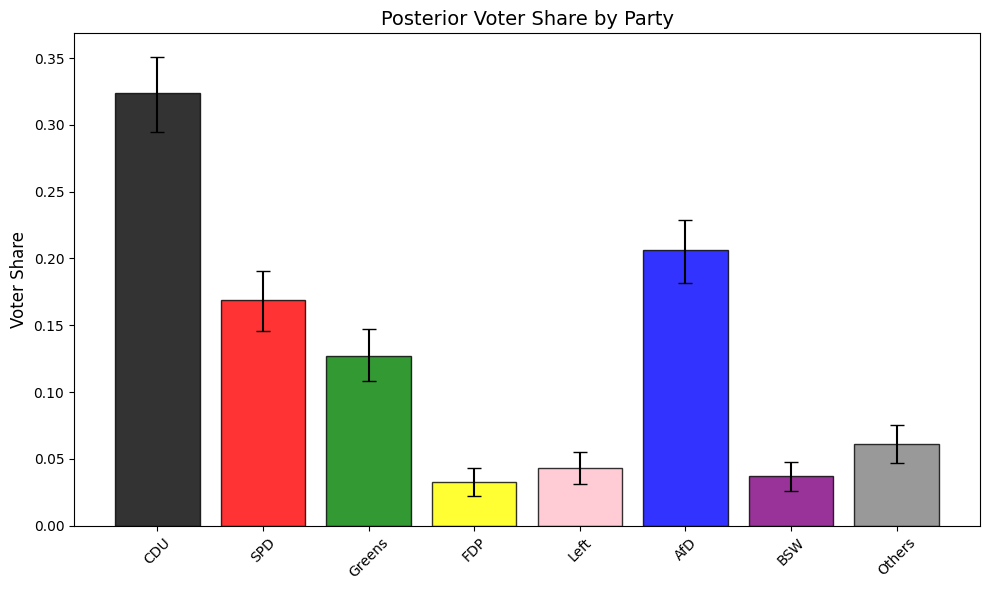

In [28]:
summary_nation = az.summary(trace, var_names=["voter_share_nation"], hdi_prob=0.90)
# create bar plot for mean values and uncertainty, suing the party colors
# Bar plot with error bars
means = summary_nation["mean"].to_list()
hdi_lower = summary_nation["hdi_5%"].to_list()
hdi_upper = summary_nation["hdi_95%"].to_list()
x = np.arange(len(means))
plt.figure(figsize=(10, 6))
plt.bar(x, means, yerr=[np.array(means) - np.array(hdi_lower), np.array(hdi_upper) - np.array(means)], 
        color=party_colors, capsize=5, alpha=0.8, edgecolor='black')
plt.xticks(x, party_labels, rotation=45, fontsize=10)
plt.ylabel('Voter Share', fontsize=12)
plt.title('Posterior Voter Share by Party', fontsize=14)
plt.tight_layout()
plt.savefig("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/results/Final/posterior_vote_share_nation")
plt.show()

Calculate the difference in forecasted votes 2025 and votes from 2021 election --> these trends might help to better predict the states outcome

In [29]:
mean_forecasted_voter_shares_nation = summary_nation['mean']
party_trends = mean_forecasted_voter_shares_nation - historical_shares_nation

In [30]:
party_trends = pd.Series(party_trends)
# Convert to NumPy array
party_trends = party_trends.to_numpy()

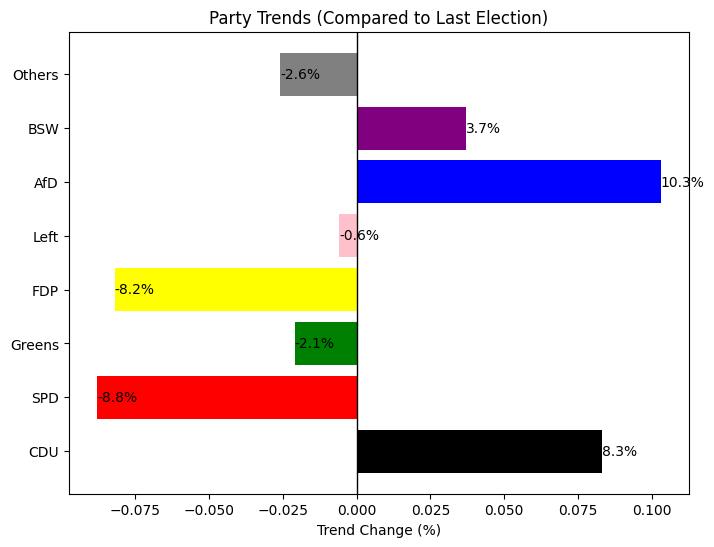

In [31]:
# Plot
plt.figure(figsize=(8, 6))

# Horizontal bar plot
bars = plt.barh(party_labels, party_trends, color=party_colors)

# Add a horizontal line at y=0 to indicate no change
plt.axvline(0, color='black',linewidth=1)

# Add labels and title
plt.xlabel('Trend Change (%)')
plt.title('Party Trends (Compared to Last Election)')

# Annotate the bars with the percentage value
for bar in bars:
    # Get the x position and the width of the bar
    width = bar.get_width()
    # Annotate the bar with the percentage
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width*100:.1f}%', 
             va='center', ha='left', color='black', fontsize=10)

# Display the plot
plt.show()

# Model for the states

## Historical data from 2021 Election

In [32]:
# Voter share for each German State 2021 (16 States x 8 Parties), Source: Bundeswahlleiterin
# The order of parties: CDU, SPD, GRÜNE, FDP, LINKE, AfD, BSW, Sonstige
historical_shares_states = np.array([
    [0.248, 0.216, 0.172, 0.153, 0.033, 0.096, 0.000, 0.082],
    [0.317, 0.180, 0.141, 0.105, 0.028, 0.090, 0.000, 0.139],
    [0.159, 0.234, 0.224, 0.091, 0.114, 0.084, 0.000, 0.094],
    [0.153, 0.295, 0.090, 0.093, 0.085, 0.181, 0.000, 0.103],
    [0.172, 0.315, 0.209, 0.093, 0.077, 0.069, 0.000, 0.065],
    [0.154, 0.297, 0.249, 0.114, 0.067, 0.050, 0.000, 0.068],
    [0.228, 0.276, 0.158, 0.128, 0.043, 0.088, 0.000, 0.079],
    [0.174, 0.291, 0.078, 0.082, 0.111, 0.180, 0.000, 0.084],
    [0.242, 0.331, 0.161, 0.105, 0.033, 0.074, 0.000, 0.054],
    [0.260, 0.291, 0.161, 0.114, 0.037, 0.073, 0.000, 0.065],
    [0.247, 0.294, 0.126, 0.117, 0.033, 0.092, 0.000, 0.092],
    [0.236, 0.373, 0.000, 0.115, 0.072, 0.100, 0.000, 0.105],
    [0.172, 0.193, 0.086, 0.110, 0.093, 0.246, 0.000, 0.099],
    [0.210, 0.254, 0.065, 0.095, 0.096, 0.196, 0.000, 0.084],
    [0.220, 0.280, 0.183, 0.125, 0.036, 0.068, 0.000, 0.087],
    [0.169, 0.234, 0.066, 0.090, 0.114, 0.240, 0.000, 0.087]
])

Idea: Use the party trends as mean for a normal distribution and then draw from the normal distribution for each state a trend for each party which will be added to the historical result and this will in turn become the prior for the states.

In [ ]:
std_dev = 0.05

# Create the adjusted historical shares with the trend added from a normal distribution
np.random.seed(42)  # Set seed for reproducibility
trend_adj_hss = historical_shares_states.copy()  # Copy to avoid modifying the original

# For each state and each party, draw a sample from the normal distribution and add it to historical shares
for i in range(len(historical_shares_states)):
    for j in range(len(party_trends)):
        trend_adjustment = np.random.normal(party_trends[j], std_dev)  # Draw from the normal distribution
        trend_adj_hss[i, j] += trend_adjustment  # Add the trend to the historical share

# Ensure no negative values, as the share should always be between 0 and 1
trend_adj_hss = np.clip(trend_adj_hss, 0, 1)

In [34]:
trend_adj_hss

array([[0.35583571, 0.12108678, 0.18338443, 0.14715149, 0.01529233,
        0.18729315, 0.11596064, 0.09437174],
       [0.37652628, 0.119128  , 0.09682912, 0.        , 0.03409811,
        0.09733599, 0.        , 0.08488562],
       [0.19135844, 0.16171237, 0.1575988 , 0.        , 0.18128244,
        0.17571118, 0.04037641, 0.        ],
       [0.20878086, 0.21254613, 0.01145032, 0.0297849 , 0.04896807,
        0.26941531, 0.00691467, 0.16961391],
       [0.25432514, 0.17411445, 0.22912725, 0.        , 0.08144318,
        0.07401649, 0.        , 0.04884306],
       [0.27392333, 0.21756841, 0.22221759, 0.01694482, 0.        ,
        0.11700779, 0.01396806, 0.09485611],
       [0.32818091, 0.09984799, 0.1532042 , 0.02674589, 0.0031539 ,
        0.22158381, 0.08854998, 0.09956401],
       [0.21503912, 0.18753938, 0.07356317, 0.04877726, 0.08104129,
        0.27371705, 0.        , 0.        ],
       [0.36562629, 0.310812  , 0.13639949, 0.07317664, 0.0450818 ,
        0.14474401, 0.055069

One issue in the data is that in Saarland, the greens got 0% in 2021. If i add the trend from national level, then they get into negative values, which clearly do not make sense. 

In [35]:
trend_adj_hss[trend_adj_hss <= 0] = 1e-3

In [36]:
alpha_states = trend_adj_hss * 100 # alphas represent pseudo counts

In [37]:
state_mapping = {
    "baden-wuerttemberg": "BW",
    "bayern": "BY",
    "berlin": "BE",
    "brandenburg": "BB",
    "bremen": "HB",
    "hamburg": "HH",
    "hessen": "HE",
    "mecklenburg-vorpommern": "MV",
    "niedersachsen": "NI",
    "nordrhein-westfalen-nrw": "NW",
    "rheinland-pfalz": "RP",
    "saarland": "SL",
    "sachsen": "SN",
    "sachsen-anhalt": "ST",
    "schleswig-holstein": "SH",
    "thueringen": "TH"
}

In [38]:
# Include longer timeframe as there might be no/less polls for states
state_polls = get_poll_data("2024-11-07", False)
# create dict with states as keys and the corresponding polls as values
state_polls_dict = {}
state_polls = state_polls.fillna(0)
polls_grouped_by_state = state_polls.groupby('parliament_id')
for state, polls in polls_grouped_by_state:
    state = state_mapping[state]
    for var in ["cdu-csu", "spd", "gruene", "fdp", "linke", "afd", "bsw", "sonstige"]:
        polls[var] = round(polls["survey_persons"] * polls[var] / 100)
    # sum up the polls for each state
    polls = polls.drop(columns=["survey_persons", "institute_id", "survey_date", "parliament_id"])
    polls = polls.fillna(0)
    polls.reset_index(drop=True, inplace=True)
    poll_results_state = polls.values.tolist()
    sample_size_state = polls.sum(axis=1).to_list()
    state_polls_dict[state] = {
        'poll_results': poll_results_state,
        'sample_size': sample_size_state
    }

In [39]:
print(state_polls_dict)

{'BW': {'poll_results': [[310.0, 130.0, 200.0, 50.0, 40.0, 180.0, 50.0, 40.0], [381.0, 150.0, 254.0, 46.0, 0.0, 173.0, 46.0, 104.0], [340.0, 110.0, 200.0, 60.0, 30.0, 170.0, 60.0, 30.0]], 'sample_size': [1000.0, 1154.0, 1000.0]}, 'BY': {'poll_results': [[2204.0, 401.0, 551.0, 100.0, 50.0, 601.0, 200.0, 351.0]], 'sample_size': [4458.0]}, 'BE': {'poll_results': [[318.0, 141.0, 236.0, 47.0, 71.0, 177.0, 83.0, 106.0]], 'sample_size': [1179.0]}, 'BB': {'poll_results': [[170.0, 250.0, 30.0, 20.0, 50.0, 290.0, 130.0, 40.0], [177.0, 331.0, 59.0, 0.0, 47.0, 355.0, 142.0, 71.0]], 'sample_size': [980.0, 1182.0]}, 'HH': {'poll_results': [[222.0, 419.0, 235.0, 39.0, 131.0, 131.0, 39.0, 52.0], [190.0, 338.0, 200.0, 32.0, 95.0, 95.0, 32.0, 42.0], [210.0, 361.0, 233.0, 35.0, 93.0, 105.0, 35.0, 93.0], [142.0, 303.0, 178.0, 27.0, 53.0, 98.0, 27.0, 36.0], [197.0, 359.0, 255.0, 46.0, 58.0, 104.0, 46.0, 93.0], [151.0, 284.0, 177.0, 35.0, 62.0, 89.0, 35.0, 35.0], [224.0, 353.0, 247.0, 35.0, 71.0, 106.0, 47.

Saarland (SL) and Bremen (HB) are missing because there exist no polls.

In [40]:
# Insert values from last available dawum polls
# Bremen: Use results from Bremische Bürgerschaftswahl 2023
# Saarland: https://dawum.de/Saarland/
state_polls_dict["HB"] = {
    'poll_results': [[179, 203, 91, 39, 77, 0, 0, 112]],
    'sample_size': [701]
}
state_polls_dict["SL"] = {
    'poll_results': [[310, 290, 50, 40, 30, 145, 100, 115]],
    'sample_size': [1080]
}
print(state_polls_dict)

{'BW': {'poll_results': [[310.0, 130.0, 200.0, 50.0, 40.0, 180.0, 50.0, 40.0], [381.0, 150.0, 254.0, 46.0, 0.0, 173.0, 46.0, 104.0], [340.0, 110.0, 200.0, 60.0, 30.0, 170.0, 60.0, 30.0]], 'sample_size': [1000.0, 1154.0, 1000.0]}, 'BY': {'poll_results': [[2204.0, 401.0, 551.0, 100.0, 50.0, 601.0, 200.0, 351.0]], 'sample_size': [4458.0]}, 'BE': {'poll_results': [[318.0, 141.0, 236.0, 47.0, 71.0, 177.0, 83.0, 106.0]], 'sample_size': [1179.0]}, 'BB': {'poll_results': [[170.0, 250.0, 30.0, 20.0, 50.0, 290.0, 130.0, 40.0], [177.0, 331.0, 59.0, 0.0, 47.0, 355.0, 142.0, 71.0]], 'sample_size': [980.0, 1182.0]}, 'HH': {'poll_results': [[222.0, 419.0, 235.0, 39.0, 131.0, 131.0, 39.0, 52.0], [190.0, 338.0, 200.0, 32.0, 95.0, 95.0, 32.0, 42.0], [210.0, 361.0, 233.0, 35.0, 93.0, 105.0, 35.0, 93.0], [142.0, 303.0, 178.0, 27.0, 53.0, 98.0, 27.0, 36.0], [197.0, 359.0, 255.0, 46.0, 58.0, 104.0, 46.0, 93.0], [151.0, 284.0, 177.0, 35.0, 62.0, 89.0, 35.0, 35.0], [224.0, 353.0, 247.0, 35.0, 71.0, 106.0, 47.

In [41]:
# create numpy array with poll data from states, but the keys should be ordered as in the states array
survey_results_states = np.array([state_polls_dict[state] for state in STATES])

In [42]:
with pm.Model() as state_model:    
    # Dirichlet-Priors
    state_priors = {}
    for index, state in enumerate(STATES):
        state_prior = pm.Dirichlet(f"voter_share_{state}", a=alpha_states[index])
        state_priors[state] = state_prior
    # State Level likelihood based on poll results -> Iterate through each state and each poll in that state
    for state_index, state in enumerate(STATES):
        state_surveys = survey_results_states[state_index]
        for poll_index in range(len(state_surveys['poll_results'])):
            state_likelihood = pm.Multinomial(
                f"state_likelihood_{state}_{poll_index}",
                n=state_surveys['sample_size'][poll_index], 
                p=state_priors[state], 
                observed=state_surveys['poll_results'][poll_index]
            )

In [ ]:
with state_model:
    trace = pm.sample(
        draws=10000,
        chains=4,
        return_inferencedata=True
        )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [voter_share_BW, voter_share_BY, voter_share_BE, voter_share_BB, voter_share_HB, voter_share_HH, voter_share_HE, voter_share_MV, voter_share_NI, voter_share_NW, voter_share_RP, voter_share_SL, voter_share_SN, voter_share_ST, voter_share_SH, voter_share_TH]


Output()

In [ ]:
summary = az.summary(trace)
summary.to_csv("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/results/Final/summary_states.csv")

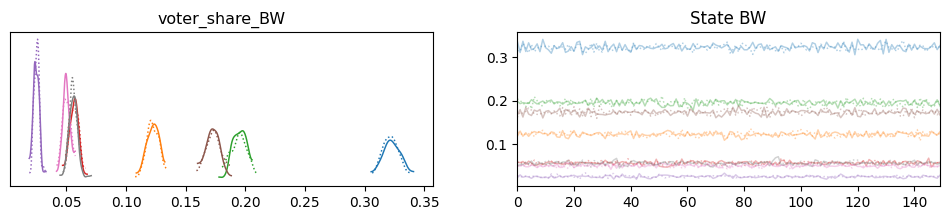

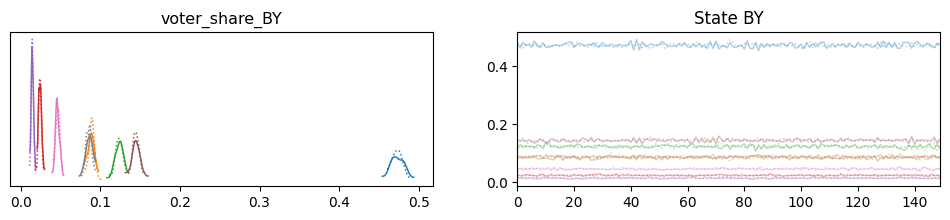

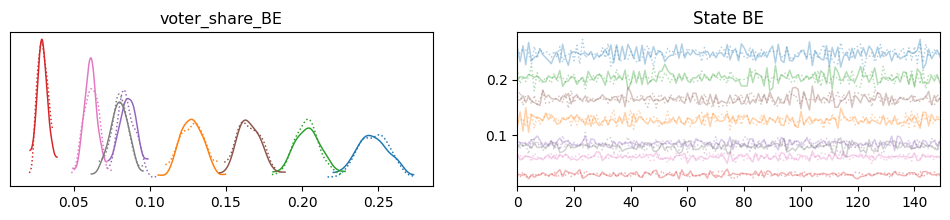

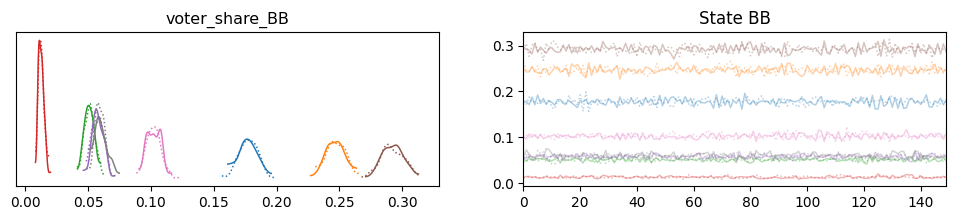

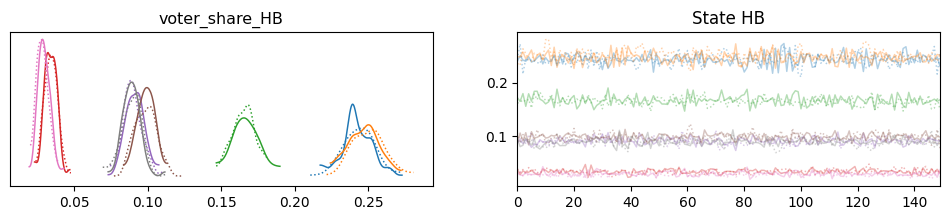

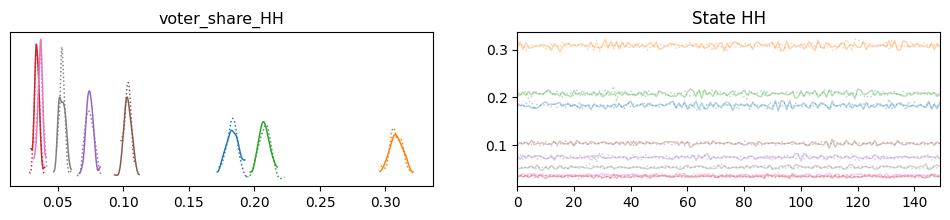

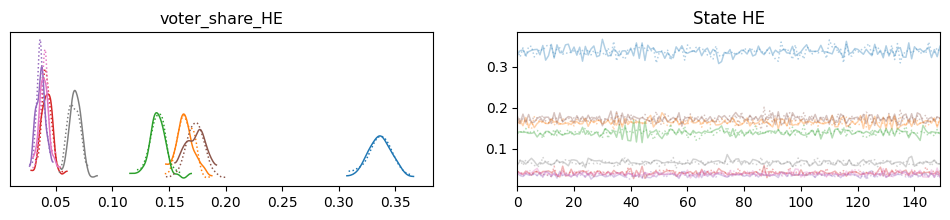

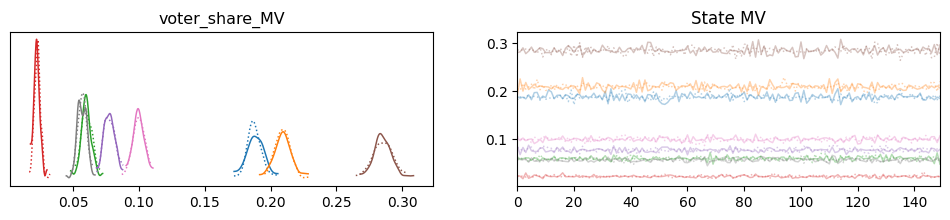

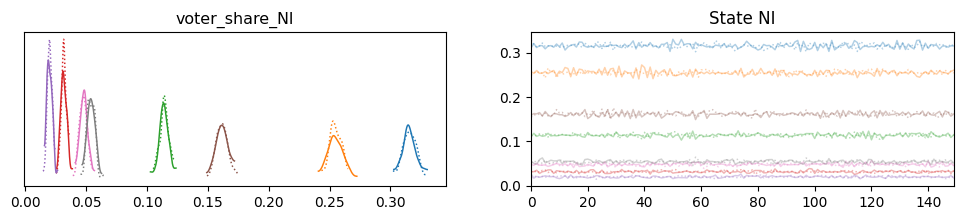

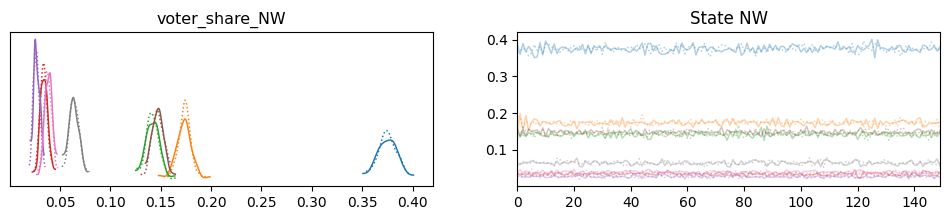

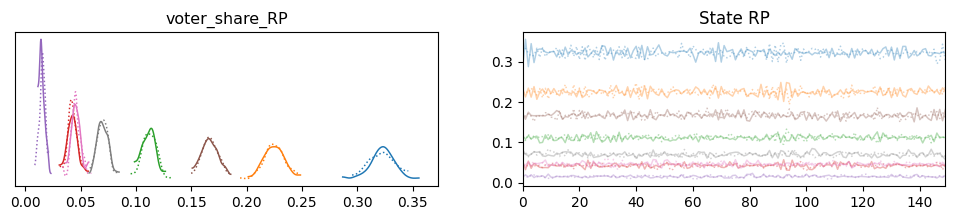

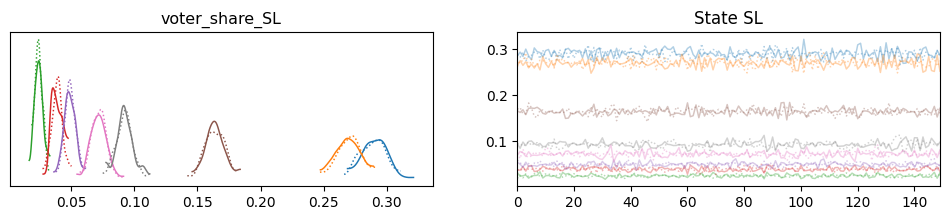

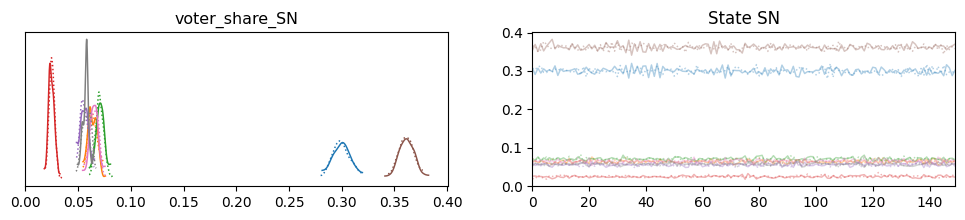

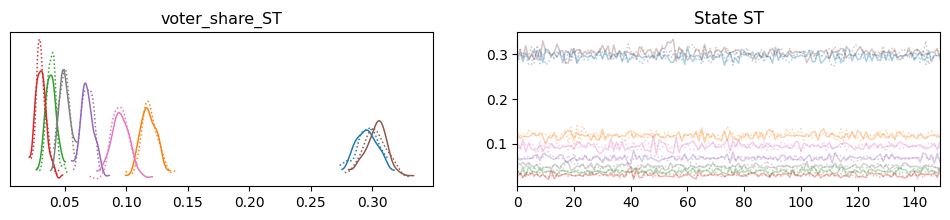

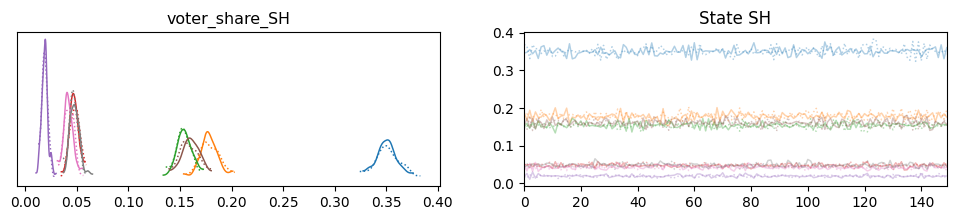

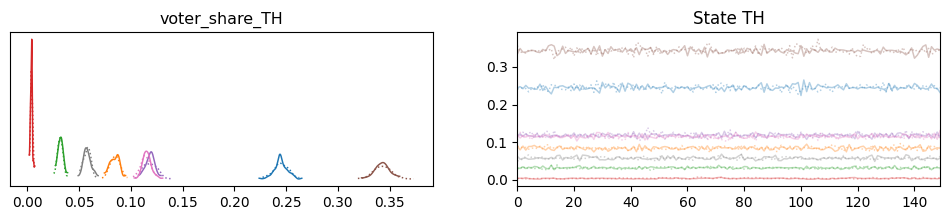

In [ ]:
party_colors = ['black', 'red', 'green', 'yellow', 'pink', 'blue', 'purple', 'grey']
party_labels = ['CDU', 'SPD', 'Grüne', 'FDP', 'Linke', 'AfD', 'BSW', 'Others']

for state in STATES:
    az.plot_trace(trace, var_names=[f"voter_share_{state}"])
    plt.title(f"State {state}")
    plt.savefig(f"/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/results/Final/state_images/{state}")
    plt.show()

In [ ]:
state_model

       voter_share_BW ~ Dirichlet(<constant>)
       voter_share_BY ~ Dirichlet(<constant>)
       voter_share_BE ~ Dirichlet(<constant>)
       voter_share_BB ~ Dirichlet(<constant>)
       voter_share_HB ~ Dirichlet(<constant>)
       voter_share_HH ~ Dirichlet(<constant>)
       voter_share_HE ~ Dirichlet(<constant>)
       voter_share_MV ~ Dirichlet(<constant>)
       voter_share_NI ~ Dirichlet(<constant>)
       voter_share_NW ~ Dirichlet(<constant>)
       voter_share_RP ~ Dirichlet(<constant>)
       voter_share_SL ~ Dirichlet(<constant>)
       voter_share_SN ~ Dirichlet(<constant>)
       voter_share_ST ~ Dirichlet(<constant>)
       voter_share_SH ~ Dirichlet(<constant>)
       voter_share_TH ~ Dirichlet(<constant>)
state_likelihood_BW_0 ~ Multinomial(1e+03, voter_share_BW)
state_likelihood_BW_1 ~ Multinomial(1.15e+03, voter_share_BW)
state_likelihood_BW_2 ~ Multinomial(1e+03, voter_share_BW)
state_likelihood_BY_0 ~ Multinomial(4.46e+03, voter_share_BY)
state_likelihood_BE_0 